In [54]:
from vtraj.ode import * 
from dataclasses import astuple, asdict

import pandas as pd


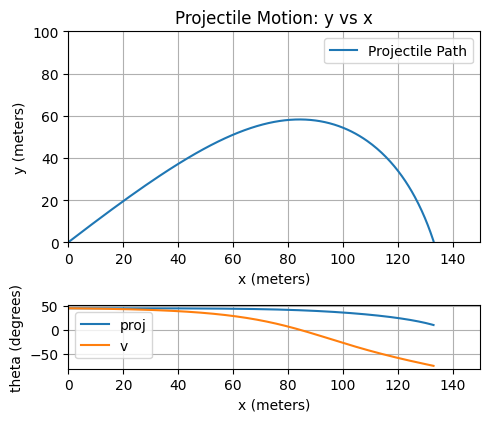

In [65]:
obs_params = Parameters(**{'Kp_theta': 0.1, 'C_d_1': 0.047, 'A_1': 0.045, 'C_d_2': 0.06, 'A_2': 0.08})
ctx = Context( error=0, dt=1 / 30, params=obs_params)

sol, df = throw(v0=100, angle=45, ctx=ctx, dense_output=True)
plot_traj(df)

In [20]:
# "Observed" data
obs = pd.DataFrame(np.hstack([sol.t.reshape((-1,1)), sol.y.T]), columns="t x y theta vx vy".split())
obs

,t,x,y,theta,vx,vy
0,0.000000,0.000000,0.000000,0.785398,70.710678,70.710678
1,0.033333,2.330100,2.324692,0.785360,69.108658,68.785359
2,0.066667,4.608115,4.586640,0.785245,67.584378,66.944812
3,0.100000,6.836536,6.788561,0.785053,66.132528,65.183212
4,0.133333,9.017695,8.932998,0.784786,64.748231,63.495208
...,...,...,...,...,...,...
254,8.466667,230.224655,3.843132,-1.055643,10.502135,-28.445008
255,8.500000,230.573223,2.893316,-1.060948,10.402954,-28.501652
256,8.533333,230.918467,1.941757,-1.066209,10.304491,-28.557186
257,8.566667,231.260407,0.988510,-1.071428,10.206748,-28.611636


In [47]:
params =  [1., 0.02,0.045,0.03,0.08 ]
Parameters(*params)

Parameters(Kp_theta=1.0, C_d_1=0.02, A_1=0.045, C_d_2=0.03, A_2=0.08)

In [80]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

# Objective function to minimize
def objective_function(params, ctx, obs, v0, angle ):

    ctx = Context( error=0, dt=1 / 30, params=Parameters(*params))

    sol, df = throw(v0=v0, angle=angle, ctx=ctx, dense_output=True)

    d = pd.DataFrame(np.hstack([sol.t.reshape((-1,1)), sol.y.T]), columns="t x y theta vx vy".split())
    
    y = sol.sol(obs['t'])

    err = np.sum(np.square(y-obs.values[:,1:].T))

    return err

params = Parameters(**{'Kp_theta': 0.5, 'C_d_1': 0.02, 'A_1': 0.02, 'C_d_2': 0.02, 'A_2': 0.02})

initial_params = np.array(astuple(obs_params))*1 # astuple(params)

# Perform the optimization
v0 = 100
angle = 45
result = minimize(objective_function, initial_params, args=(ctx, obs, v0, angle))

print("Orig Parameters:     ", astuple(obs_params))
print("Optimized parameters:", result.x)


Orig Parameters:      (0.1, 0.047, 0.045, 0.06, 0.08)
Optimized parameters: [1.09476013 0.0512605  0.01743726 0.03198724 0.07548943]


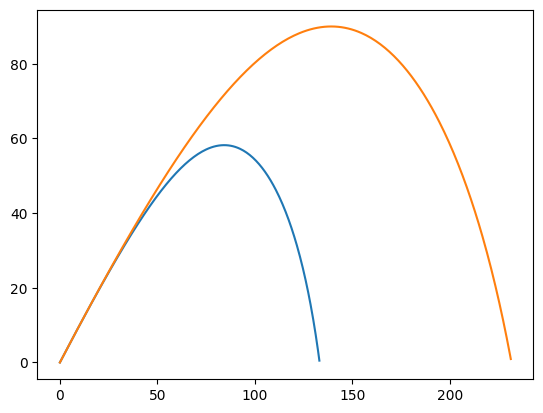

In [81]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1)

ctx = Context( error=0, dt=1 / 30, params=obs_params)
sol, df = throw(v0=v0, angle=angle, ctx=ctx, dense_output=True)

ax.plot(df.x, df.y)

ctx = Context( error=0, dt=1 / 30, params=Parameters(*result.x))
sol, df = throw(v0=v0, angle=angle, ctx=ctx, dense_output=True)

ax.plot(df.x, df.y)

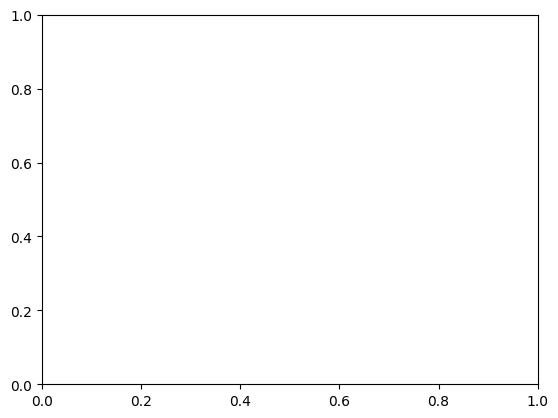